## QA script for population projections

In [1]:
import pandas as pd
import numpy as np
import pyreadr
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
#read in sample projection data
os.chdir(r'C:\Users\user\Documents\population_data')
#read in without first column
df = pd.read_csv('2019_based_projections_random_sample15000.csv', usecols = range(1, 8))


In [10]:
df

,projection_name,gss_code,year,sex,age,component,value
0,central upper,E09000001,2011,female,75,population,29
1,central upper,E09000001,2013,male,76,population,26
2,central upper,E09000001,2043,female,21,population,52
3,central upper,E09000002,2042,male,57,population,1595
4,central upper,E09000003,2037,female,83,population,1290
...,...,...,...,...,...,...,...
14995,scenario 3,E05000648,2043,female,12,total net,-6
14996,scenario 3,E05000648,2044,male,44,total net,-8
14997,scenario 3,E05000648,2049,female,64,total net,-151
14998,scenario 3,E05000649,2011,male,28,total net,16


### Basic checks

##### missing values

In [11]:
missing_values = df.isnull().sum()
print("Missing values per column:\n", missing_values)

Missing values per column:
 projection_name    0
gss_code           0
year               0
sex                0
age                0
component          0
value              0
dtype: int64


#### duplicates 

In [12]:
duplicates = df.duplicated().sum()
print("Number of duplicate rows:", duplicates)

Number of duplicate rows: 0


In [15]:
#max value of value column
max_value = df['value'].max()
print("Max value of value column:", max_value)
#max value for each component
max_component = df.groupby('component').max()
print("Max value for each component:\n", max_component)

Max value of value column: 103627
Max value for each component:
                   projection_name   gss_code  year   sex  age   value
component                                                            
births                 scenario 3  E09000031  2050  male    0    2568
deaths                 scenario 3  E12000007  2050  male   90    1068
domestic in            scenario 3  E12000007  2050  male   90    7202
domestic out           scenario 3  E12000007  2050  male   90   13827
international in       scenario 3  E12000007  2050  male   90    5662
international out      scenario 3  E12000007  2050  male   90    2156
population             scenario 3  E12000007  2050  male   90  103627
total net              scenario 3  E12000007  2050  male   90   15036


#### value range

In [18]:
# Checking for negative values and extremely high values
negative_values = df[df['value'] < 0]
print('components with negative values:', negative_values['component'].unique())

print("Rows with negative population values:\n", negative_values)


# Assuming a high threshold (e.g., 10 million) for too high population values
high_values = df[df['value'] > 1000000]
print("Rows with very high population values:\n", high_values)

components with negative values: ['total net']
Rows with negative population values:
       projection_name   gss_code  year     sex  age  component  value
11192      scenario 1  E05000029  2044    male   53  total net     -2
11201      scenario 1  E05000034  2039  female   56  total net     -2
11202      scenario 1  E05000035  2026    male   57  total net     -3
11204      scenario 1  E05000036  2024  female   62  total net     -1
11205      scenario 1  E05000036  2034    male   46  total net     -5
...               ...        ...   ...     ...  ...        ...    ...
14994      scenario 3  E05000648  2023  female   43  total net     -3
14995      scenario 3  E05000648  2043  female   12  total net     -6
14996      scenario 3  E05000648  2044    male   44  total net     -8
14997      scenario 3  E05000648  2049  female   64  total net   -151
14999      scenario 3  E05000649  2032  female    5  total net     -1

[1645 rows x 7 columns]
Rows with very high population values:
 Empty Dat

#### age

In [26]:
#print true if max age is 90 and min age is 0
print((df['age'].max() == 90) & (df['age'].min() == 0))

True


Max age: 90
Min age: 0


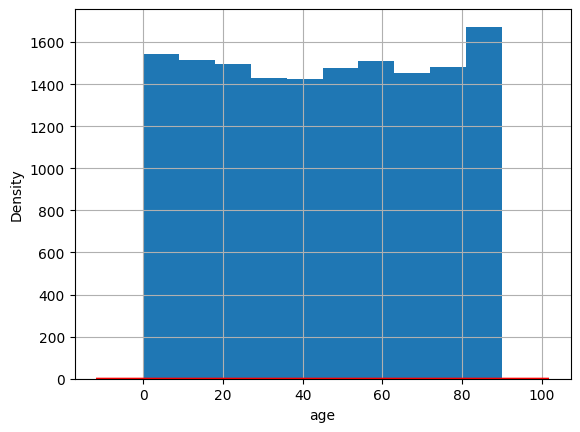

In [25]:
#display age range histogram
df['age'].hist()
#add distribution line
sns.kdeplot(df['age'], color = 'red')


#### Population Consistency Over Time

In [24]:
# Group by gss_code and sex and check population values over years
population_consistency = df.groupby(['gss_code', 'sex', 'year','component'])['value'].sum().reset_index()

# Check for unrealistic fluctuations
fluctuations = population_consistency.groupby(['gss_code', 'sex','component'])['value'].pct_change().abs()
unrealistic_fluctuations = fluctuations[fluctuations > 2]  # Assuming 200% change is too high
print("extreme population fluctuations:\n", unrealistic_fluctuations)


Unrealistic population fluctuations:
 8           6.000000
24          9.428571
29               inf
44          2.666667
49               inf
            ...     
14278      22.227848
14284       5.133761
14289       2.833333
14292    1329.000000
14293       5.347826
Name: value, Length: 2276, dtype: float64


#### Gender check

In [26]:
#### Gender Ratio
gender_ratio = df.groupby(['gss_code', 'year', 'sex'])['value'].sum().unstack().reset_index()
gender_ratio['ratio'] = gender_ratio['male'] / gender_ratio['female']
print("Gender ratios:\n", gender_ratio)

# Check for biologically implausible ratios
implausible_ratios = gender_ratio[(gender_ratio['ratio'] < 0.5) | (gender_ratio['ratio'] > 2)]
print("Implausible gender ratios:\n", implausible_ratios)

Gender ratios:
 sex     gss_code  year   female      male      ratio
0      E05000026  2012      NaN      16.0        NaN
1      E05000026  2014     47.0       NaN        NaN
2      E05000026  2017      0.0       NaN        NaN
3      E05000026  2023     -3.0     112.0 -37.333333
4      E05000026  2028      NaN       0.0        NaN
...          ...   ...      ...       ...        ...
10495  E12000007  2045    838.0     650.0   0.775656
10496  E12000007  2047  57603.0  104053.0   1.806382
10497  E12000007  2048      NaN    1330.0        NaN
10498  E12000007  2049      NaN     146.0        NaN
10499  E12000007  2050      NaN    6814.0        NaN

[10500 rows x 5 columns]
Implausible gender ratios:
 sex     gss_code  year   female     male      ratio
3      E05000026  2023     -3.0    112.0 -37.333333
5      E05000026  2029      0.0    247.0        inf
11     E05000026  2045      0.0    297.0        inf
51     E05000029  2038      3.0      0.0   0.000000
53     E05000029  2044      0.0   

#### Distributions

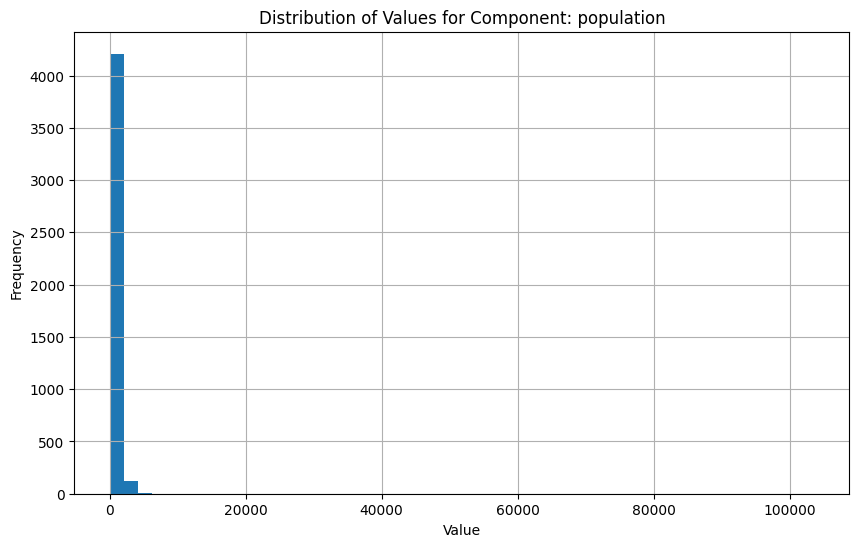

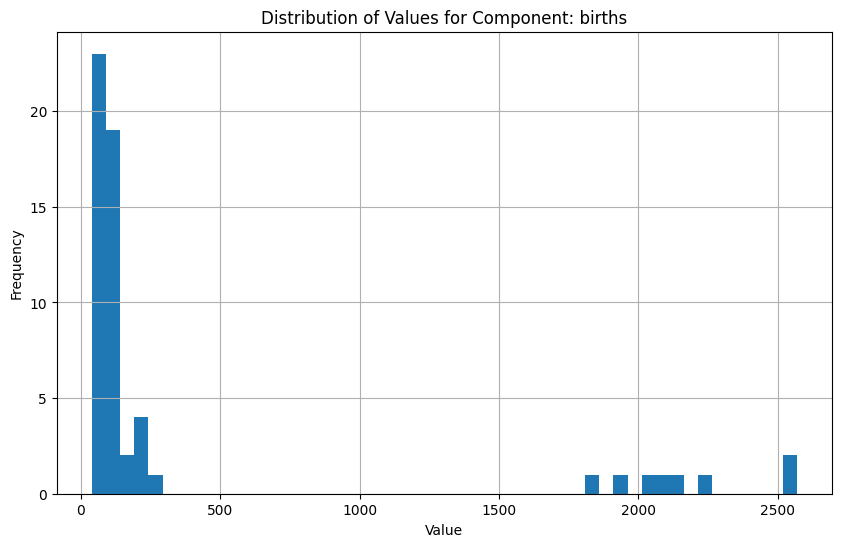

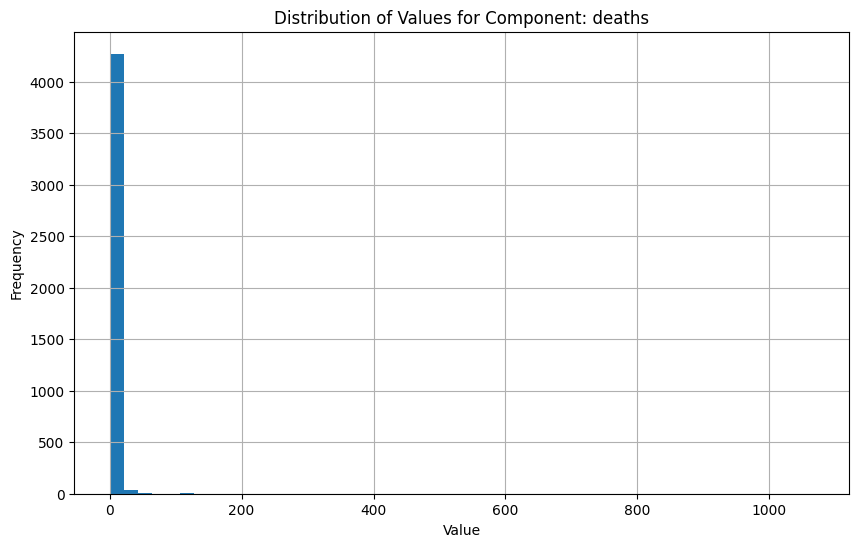

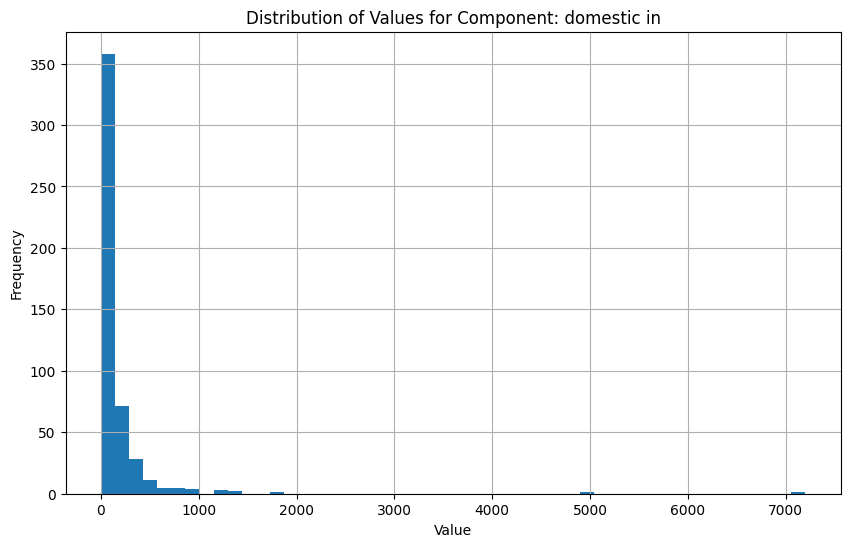

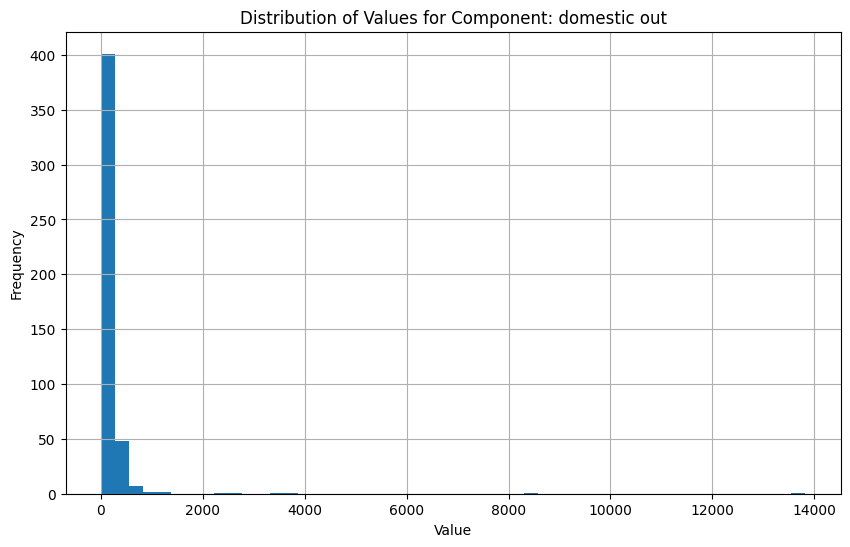

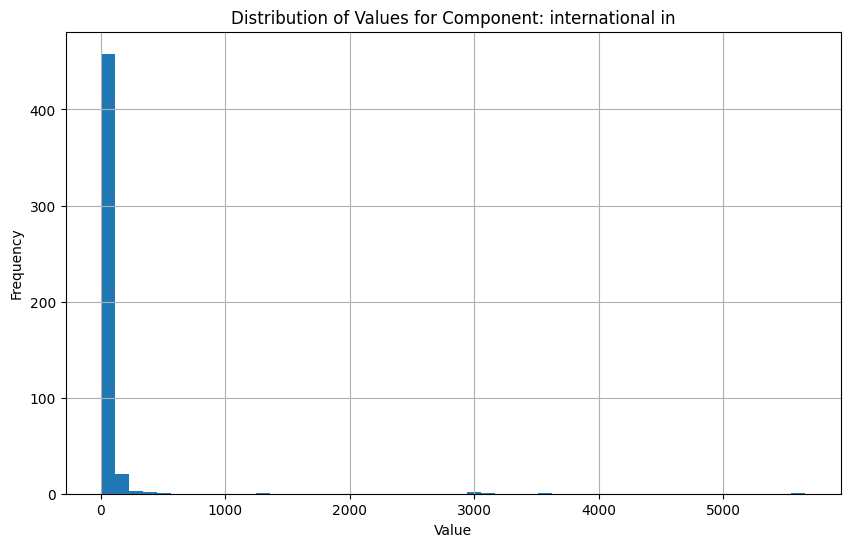

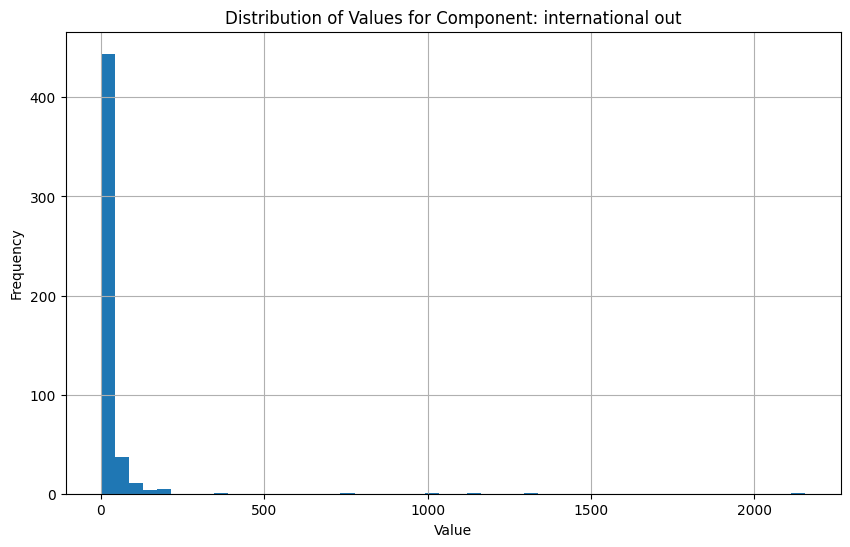

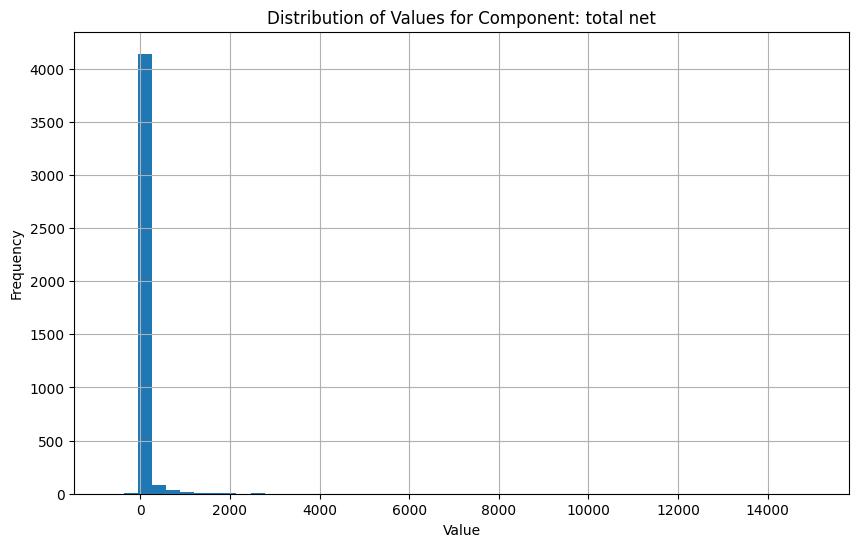

In [51]:
#distribution of values for each component
components = df['component'].unique()

for component in components:
    plt.figure(figsize=(10, 6))
    subset = df[df['component'] == component]
    subset['value'].hist(bins=50)
    plt.title(f'Distribution of Values for Component: {component}')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.show()


#### components by age

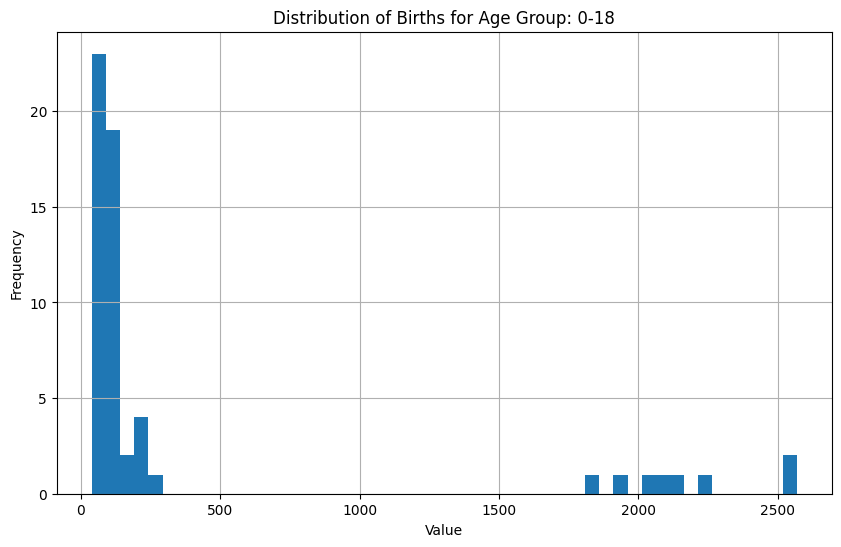

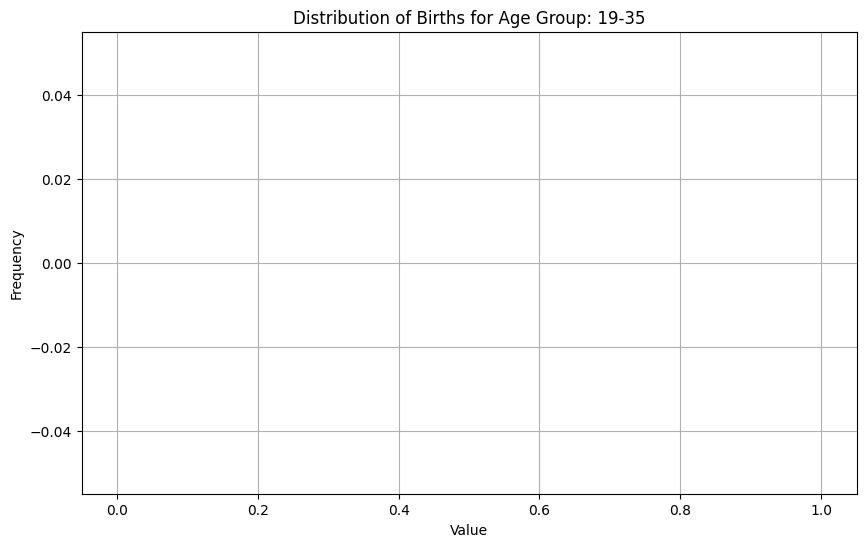

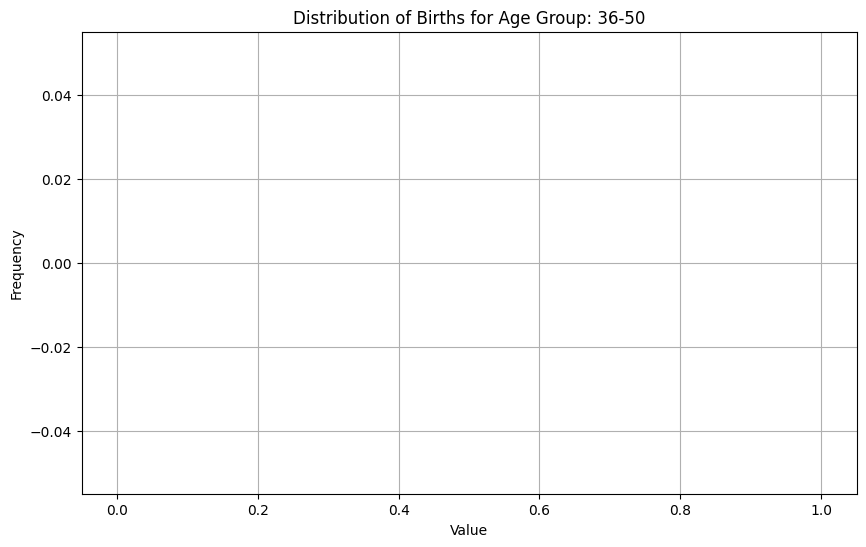

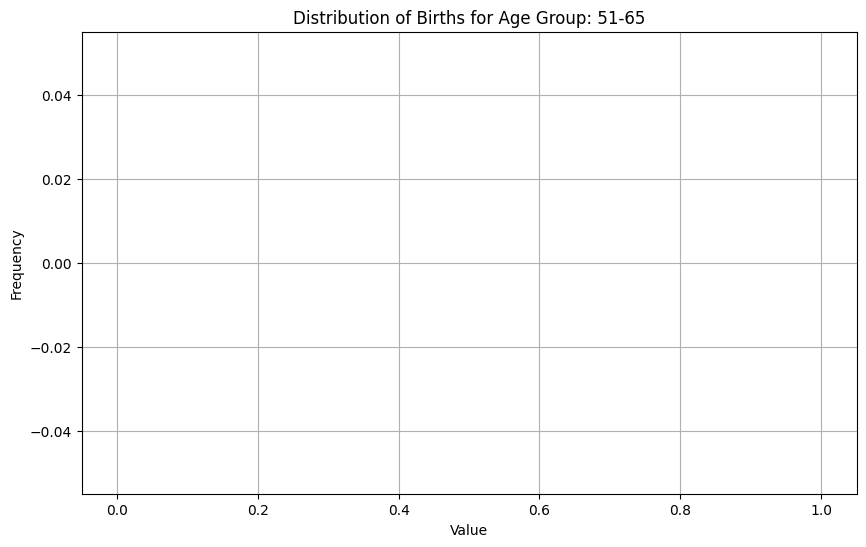

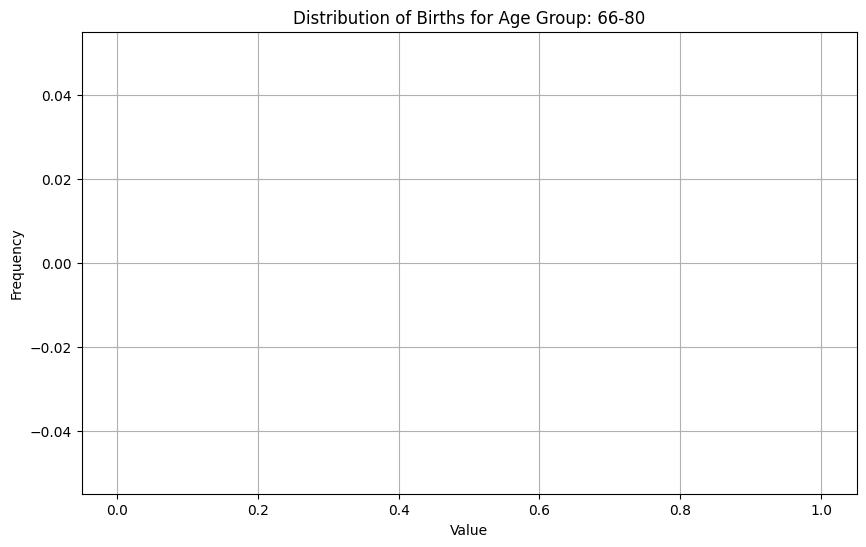

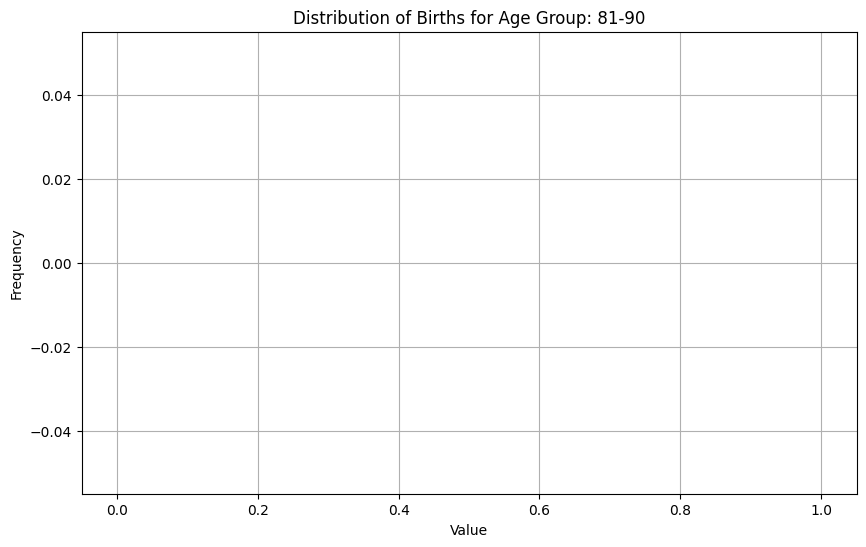

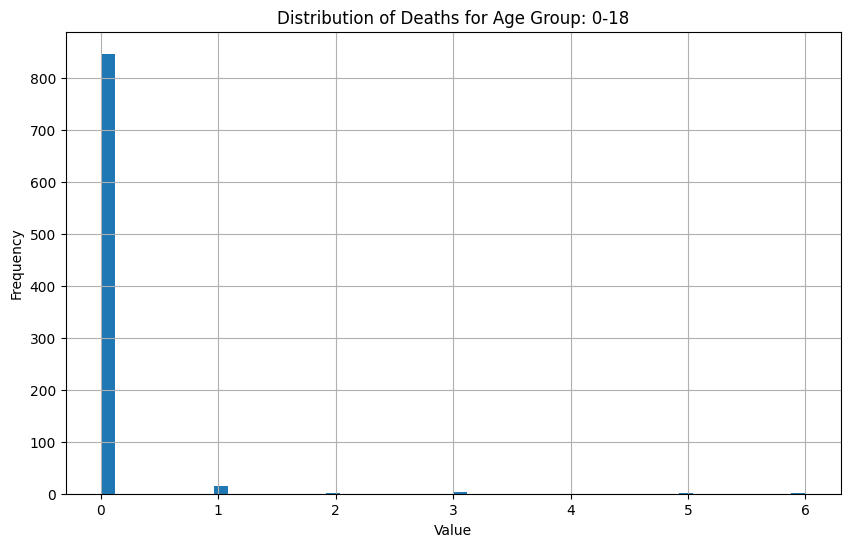

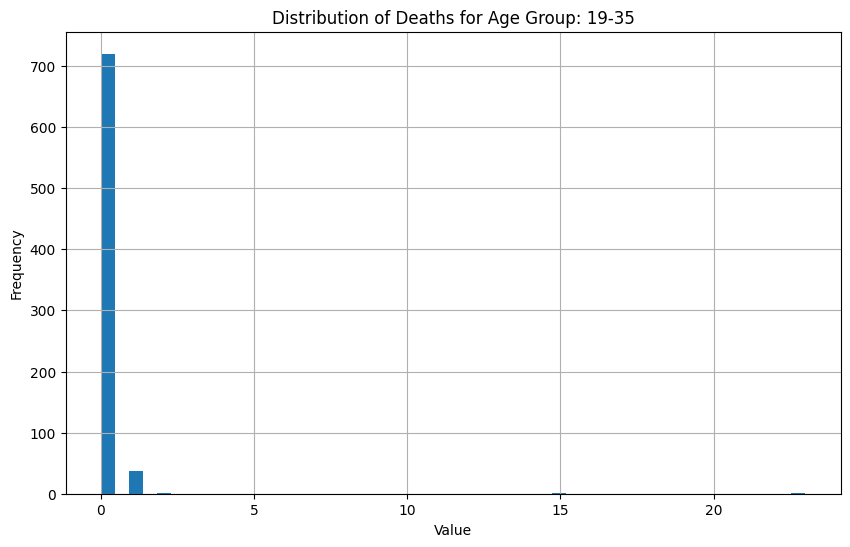

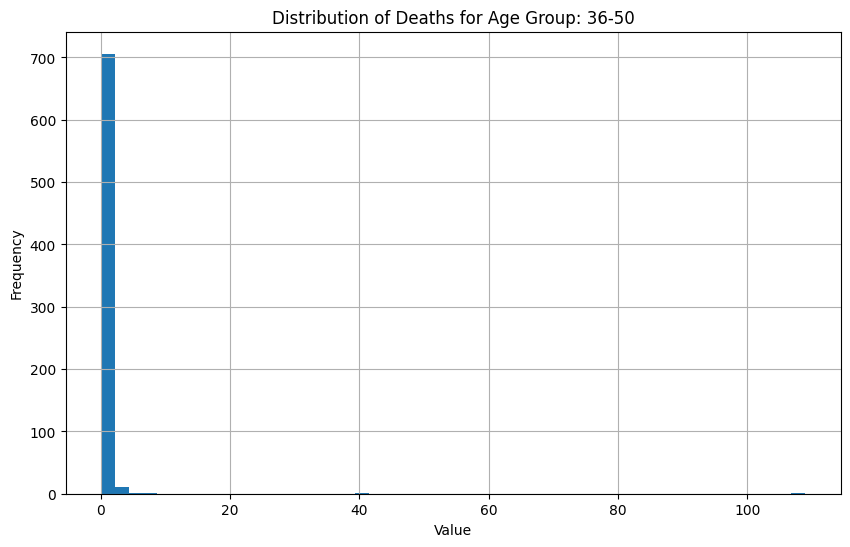

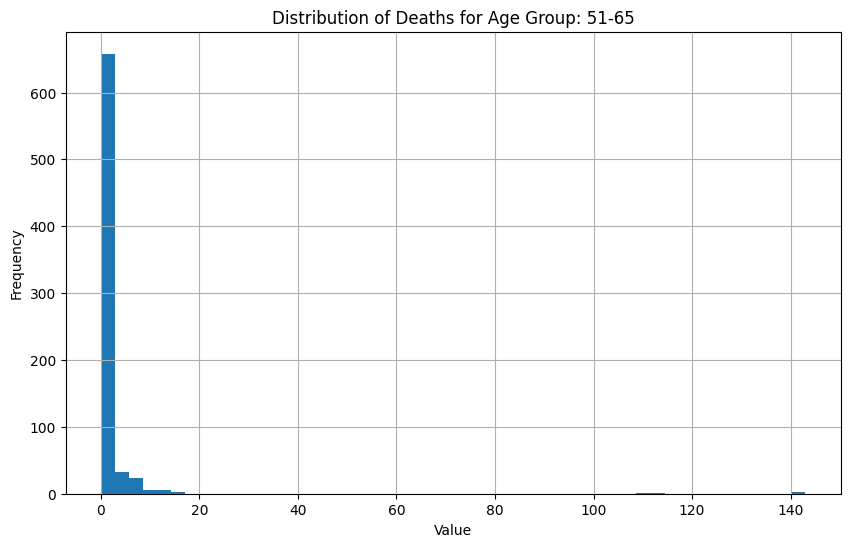

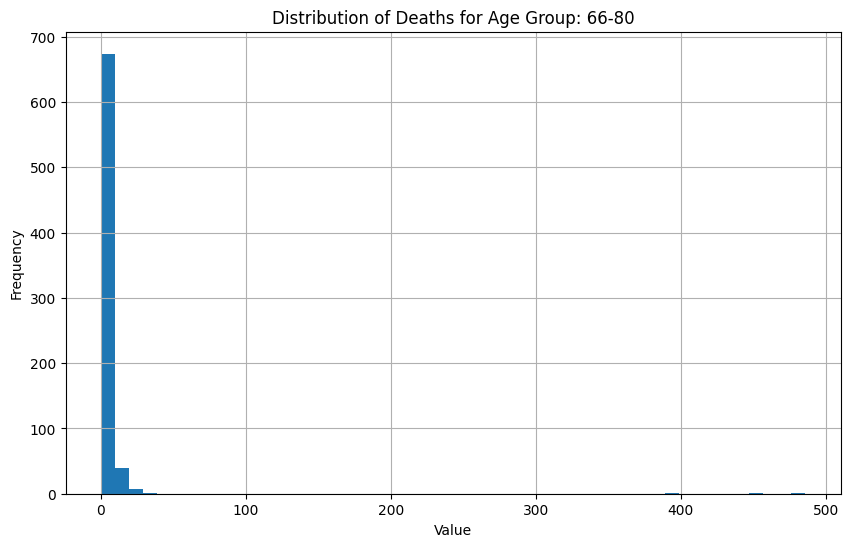

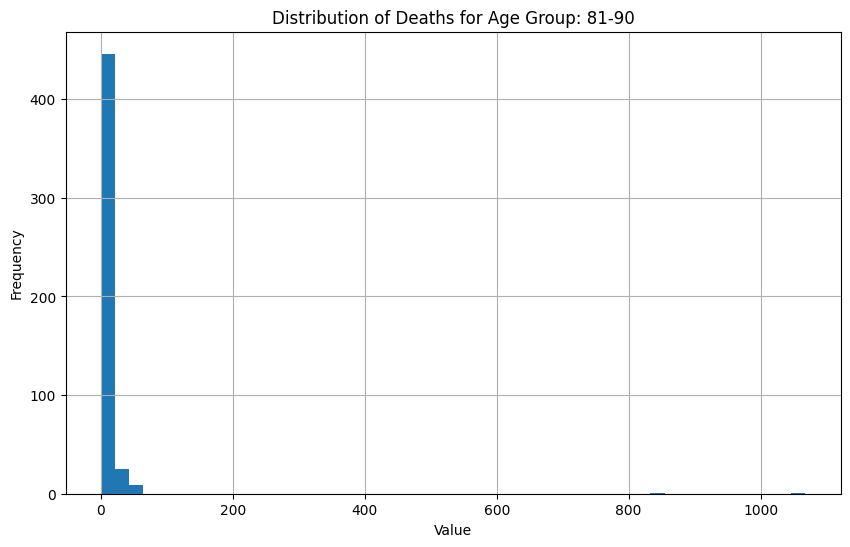

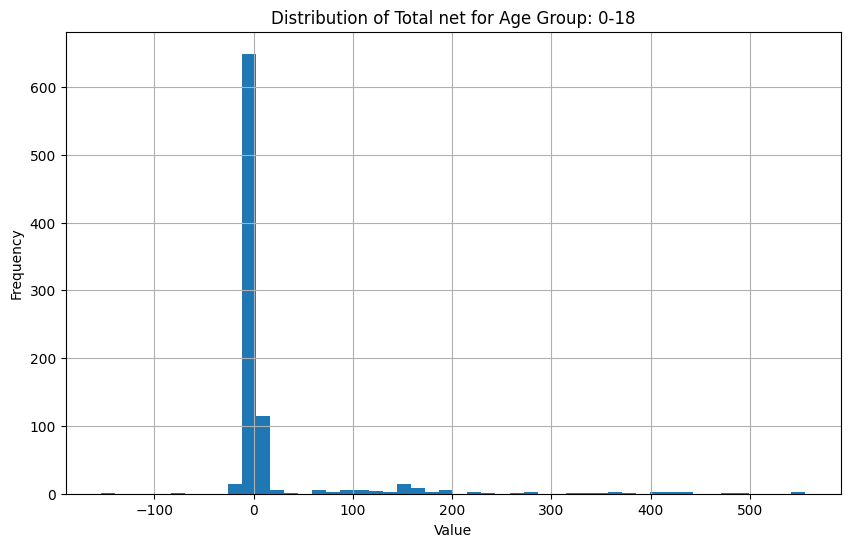

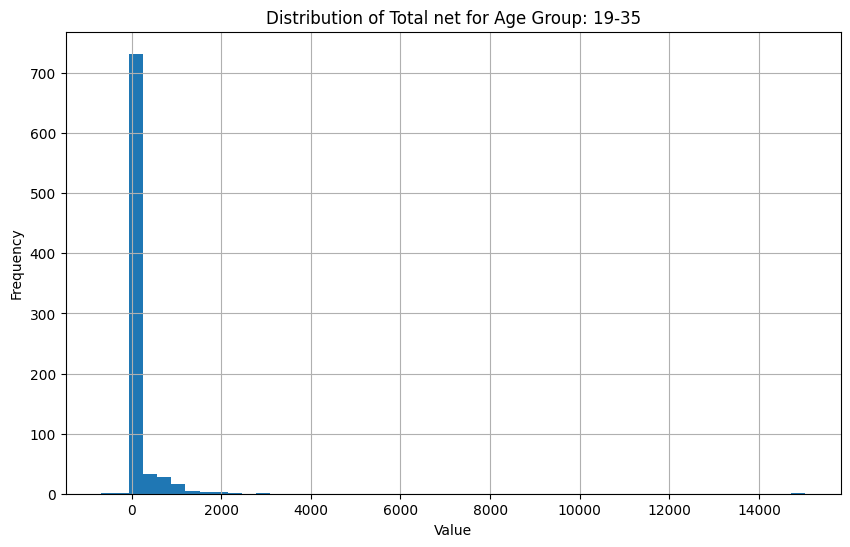

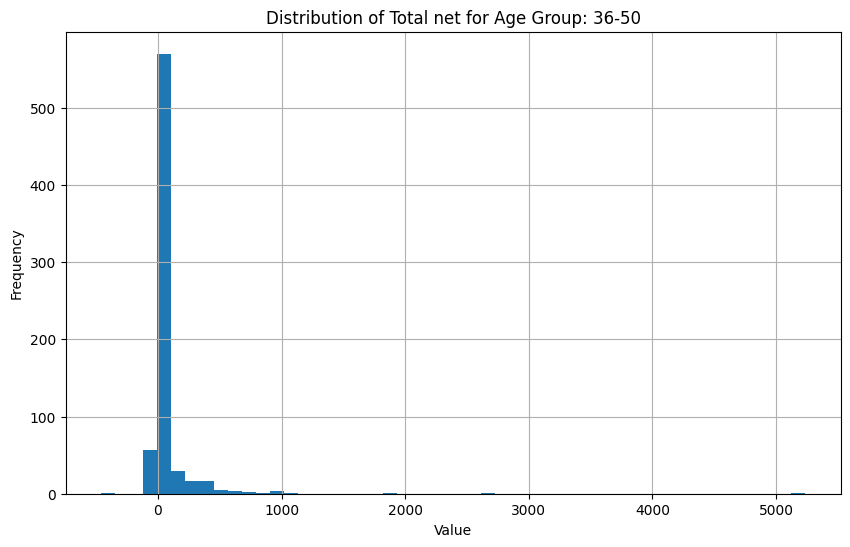

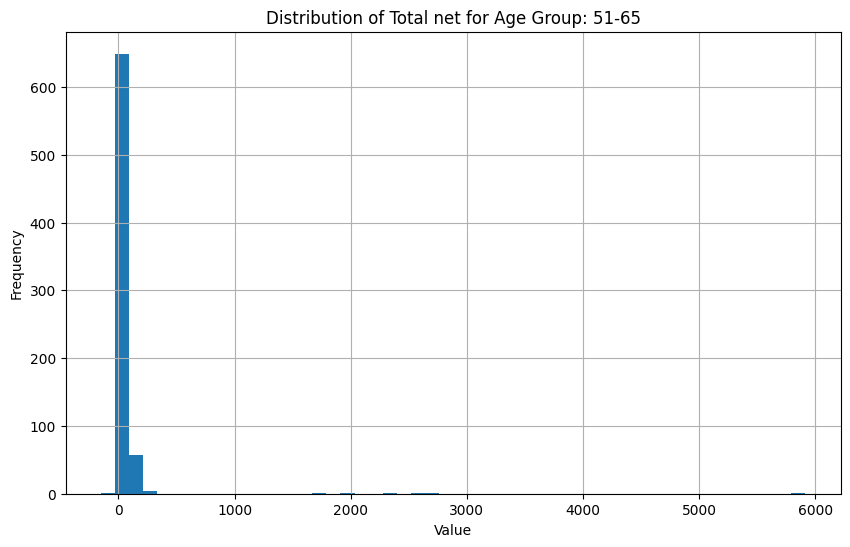

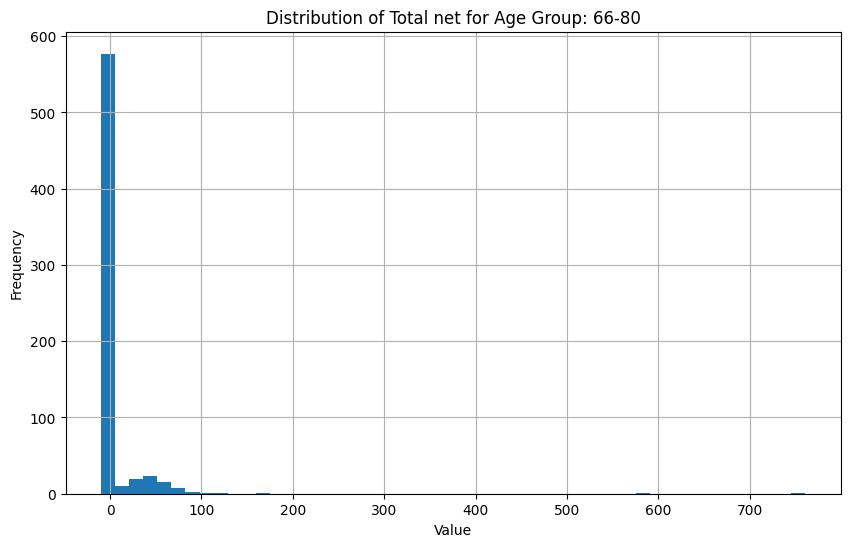

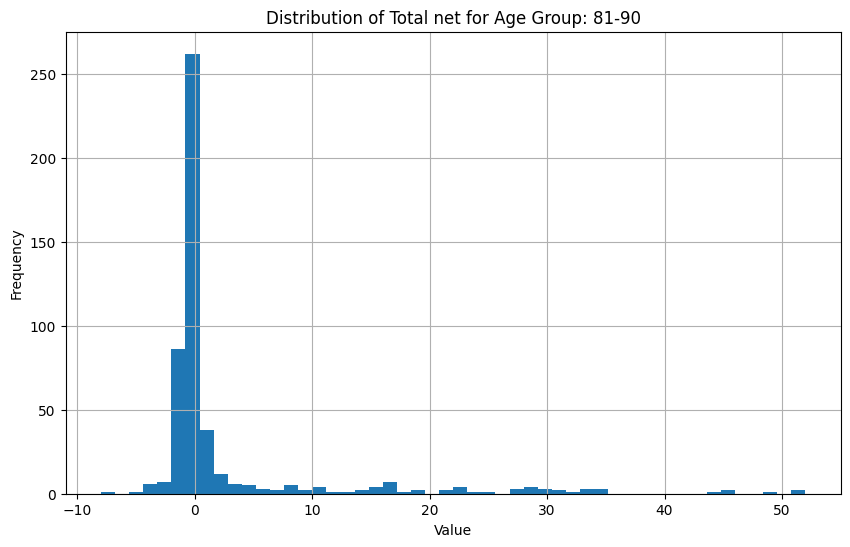

In [52]:
# Define age range groups
bins = [0, 18, 35, 50, 65, 80, 90]
labels = ['0-18', '19-35', '36-50', '51-65', '66-80', '81-90']
df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels, right=False)

# Components of interest
components_of_interest = ['births', 'deaths', 'total net']

# Plot distribution for each component by age group
for component in components_of_interest:
    for age_group in labels:
        plt.figure(figsize=(10, 6))
        subset = df[(df['component'] == component) & (df['age_group'] == age_group)]
        subset['value'].hist(bins=50)
        plt.title(f'Distribution of {component.capitalize()} for Age Group: {age_group}')
        plt.xlabel('Value')
        plt.ylabel('Frequency')
        plt.show()

#### yearly totals

In [53]:
yearly_totals = df.groupby(['gss_code', 'year','component'])['value'].sum().reset_index()
print("Yearly population totals by gss_code and year:\n", yearly_totals)

Yearly population totals by gss_code and year:
         gss_code  year          component   value
0      E05000026  2012         population      16
1      E05000026  2014         population      47
2      E05000026  2017             deaths       0
3      E05000026  2023         population     112
4      E05000026  2023          total net      -3
...          ...   ...                ...     ...
13623  E12000007  2047         population  160378
13624  E12000007  2048  international out    1330
13625  E12000007  2049             deaths     146
13626  E12000007  2050        domestic in     898
13627  E12000007  2050          total net    5916

[13628 rows x 4 columns]


#### Statistical summaries

In [54]:
# Statistical summary for each component
components = df['component'].unique()
for component in components:
    subset = df[df['component'] == component]
    print(f"Statistical summary for {component}:")
    print(subset['value'].describe())
    print("\n")


Statistical summary for population:
count      4345.000000
mean        435.927503
std        3587.895357
min           0.000000
25%          53.000000
50%          80.000000
75%         119.000000
max      103627.000000
Name: value, dtype: float64


Statistical summary for births:
count      57.000000
mean      395.000000
std       732.133648
min        40.000000
25%        72.000000
50%       103.000000
75%       163.000000
max      2568.000000
Name: value, dtype: float64


Statistical summary for deaths:
count    4331.000000
mean        2.200647
std        25.325633
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max      1068.000000
Name: value, dtype: float64


Statistical summary for domestic in:
count     490.000000
mean      154.130612
std       439.999195
min         0.000000
25%        20.000000
50%        54.500000
75%       149.000000
max      7202.000000
Name: value, dtype: float64


Statistical summary for domestic out:
count      466.00

#### Z scores

In [30]:
from scipy.stats import zscore
components = df['component'].unique()
# Z-score analysis for each component
for component in components:
    subset = df[df['component'] == component]
    subset['z_score'] = zscore(subset['value'])
    outliers = subset[(subset['z_score'].abs() > 3)]  # Z-score threshold for outliers
    print(f"Outliers for {component} based on Z-score:\n", outliers)
    print("\n")


Outliers for population based on Z-score:
       projection_name   gss_code  year     sex  age   component   value  \
61      central upper  E12000007  2012    male   15  population   47371   
62      central upper  E12000007  2020  female   66  population   34859   
63      central upper  E12000007  2028    male   83  population   14391   
64      central upper  E12000007  2030  female   25  population   76888   
65      central upper  E12000007  2030  female   29  population   75131   
126    centrral lower  E12000007  2019    male   50  population   57166   
127    centrral lower  E12000007  2027    male   26  population   70814   
128    centrral lower  E12000007  2039    male   88  population   11371   
129    centrral lower  E12000007  2040    male   41  population   69747   
130    centrral lower  E12000007  2042  female   63  population   55691   
265   high population  E12000007  2012  female   68  population   27463   
266   high population  E12000007  2036  female   16  popu

C:\Users\user\AppData\Local\Temp\ipykernel_28468\3015217694.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['z_score'] = zscore(subset['value'])
C:\Users\user\AppData\Local\Temp\ipykernel_28468\3015217694.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['z_score'] = zscore(subset['value'])
C:\Users\user\AppData\Local\Temp\ipykernel_28468\3015217694.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

#### Anomaly Detection, IsolationForest

In [32]:
# Anomaly Detection
from sklearn.ensemble import IsolationForest

# Apply Isolation Forest for anomaly detection
model = IsolationForest(contamination=0.01)
for component in components:
    subset = df[df['component'] == component]
    subset['anomaly'] = model.fit_predict(subset[['value']])
    anomalies = subset[subset['anomaly'] == -1]
    print(f"Anomalies detected in {component} using Isolation Forest:\n", anomalies)
    print("\n")

C:\Users\user\AppData\Local\Temp\ipykernel_28468\2865396599.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['anomaly'] = model.fit_predict(subset[['value']])
C:\Users\user\AppData\Local\Temp\ipykernel_28468\2865396599.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['anomaly'] = model.fit_predict(subset[['value']])


Anomalies detected in population using Isolation Forest:
       projection_name   gss_code  year     sex  age   component   value  \
14      central upper  E09000007  2039    male   31  population    3752   
15      central upper  E09000008  2033  female   51  population    3159   
16      central upper  E09000008  2044    male   35  population    3236   
20      central upper  E09000009  2050    male   29  population    2940   
25      central upper  E09000012  2042  female   25  population    3111   
47      central upper  E09000025  2034    male   39  population    3439   
48      central upper  E09000025  2035    male   33  population    3991   
61      central upper  E12000007  2012    male   15  population   47371   
62      central upper  E12000007  2020  female   66  population   34859   
63      central upper  E12000007  2028    male   83  population   14391   
64      central upper  E12000007  2030  female   25  population   76888   
65      central upper  E12000007  2030  fe

C:\Users\user\AppData\Local\Temp\ipykernel_28468\2865396599.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['anomaly'] = model.fit_predict(subset[['value']])


Anomalies detected in deaths using Isolation Forest:
       projection_name   gss_code  year     sex  age component  value  anomaly
290     central upper  E09000009  2027  female   87    deaths     34       -1
292     central upper  E09000010  2043  female   84    deaths     46       -1
316     central upper  E09000018  2045  female   84    deaths     40       -1
332     central upper  E09000026  2050    male   83    deaths     42       -1
339     central upper  E09000029  2046    male   87    deaths     43       -1
340     central upper  E09000029  2048    male   88    deaths     45       -1
372    centrral lower  E09000020  2024  female   90    deaths    125       -1
386    centrral lower  E09000031  2047    male   90    deaths    241       -1
387    centrral lower  E09000032  2011  female   90    deaths    236       -1
393    centrral lower  E09000033  2039    male   89    deaths     29       -1
394    centrral lower  E12000007  2045  female   80    deaths    838       -1
400    low

C:\Users\user\AppData\Local\Temp\ipykernel_28468\2865396599.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['anomaly'] = model.fit_predict(subset[['value']])


Anomalies detected in domestic in using Isolation Forest:
       projection_name   gss_code  year     sex  age    component  value  \
593     central upper  E12000007  2017  female   27  domestic in   4928   
656    centrral lower  E09000032  2014  female   24  domestic in   1312   
740    low population  E12000007  2024  female   22  domestic in   7202   
802   high population  E09000032  2044  female   26  domestic in   1430   
2529       scenario 3  E12000007  2041  female    9  domestic in   1749   

      anomaly  
593        -1  
656        -1  
740        -1  
802        -1  
2529       -1  




C:\Users\user\AppData\Local\Temp\ipykernel_28468\2865396599.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['anomaly'] = model.fit_predict(subset[['value']])


Anomalies detected in domestic out using Isolation Forest:
       projection_name   gss_code  year     sex  age     component  value  \
871     central upper  E12000007  2015    male   25  domestic out   2583   
923    centrral lower  E12000007  2037    male   25  domestic out   3670   
1071  high population  E12000007  2034  female   34  domestic out   3427   
2730       scenario 1  E12000007  2030  female   26  domestic out  13827   
2731       scenario 3  E12000007  2015    male   27  domestic out   8393   

      anomaly  
871        -1  
923        -1  
1071       -1  
2730       -1  
2731       -1  




C:\Users\user\AppData\Local\Temp\ipykernel_28468\2865396599.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['anomaly'] = model.fit_predict(subset[['value']])


Anomalies detected in international in using Isolation Forest:
      projection_name   gss_code  year     sex  age         component  value  \
2951      scenario 2  E12000007  2011  female   19  international in   3538   
2952      scenario 2  E12000007  2011  female   26  international in   5662   
2953      scenario 2  E12000007  2039    male   31  international in   3023   
2955      scenario 3  E12000007  2020    male   28  international in   3168   
2956      scenario 3  E12000007  2031    male   31  international in   3023   

      anomaly  
2951       -1  
2952       -1  
2953       -1  
2955       -1  
2956       -1  




C:\Users\user\AppData\Local\Temp\ipykernel_28468\2865396599.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['anomaly'] = model.fit_predict(subset[['value']])


Anomalies detected in international out using Isolation Forest:
      projection_name   gss_code  year     sex  age          component  value  \
1416   central upper  E12000007  2030    male   39  international out    996   
3161      scenario 2  E12000007  2016  female   38  international out    776   
3162      scenario 2  E12000007  2027  female   25  international out   2156   
3164      scenario 2  E12000007  2048    male   36  international out   1330   
3165      scenario 3  E12000007  2027  female   18  international out    375   
3167      scenario 3  E12000007  2038    male    2  international out   1135   

      anomaly  
1416       -1  
3161       -1  
3162       -1  
3164       -1  
3165       -1  
3167       -1  


Anomalies detected in total net using Isolation Forest:
       projection_name   gss_code  year     sex  age  component  value  anomaly
1682    central upper  E09000019  2036    male   21  total net   1037       -1
1686    central upper  E09000022  2038    mal

C:\Users\user\AppData\Local\Temp\ipykernel_28468\2865396599.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['anomaly'] = model.fit_predict(subset[['value']])


In [33]:
# import matplotlib.pyplot as plt

# # Time series analysis for each component
# for component in components:
#     plt.figure(figsize=(10, 6))
#     for gss_code in df['gss_code'].unique():
#         subset = df[(df['component'] == component) & (df['gss_code'] == gss_code)]
#         subset.groupby('year')['value'].sum().plot(label=gss_code)
#     plt.title(f'Time Series of {component.capitalize()} by Year')
#     plt.xlabel('Year')
#     plt.ylabel('Value')
#     plt.legend()
#     plt.show()
